# XGBoost Traning - Bandgap Dataset

## Part 1: Without 10-fold cross-validation

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

%matplotlib inline

/Users/alisonrhoads/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


I am training the XGBoost model on the normalized bandgap dataset `x_y_bandgap_normalized.csv`

MinMaxScaling was used to normalized the data

The dataset contains:
- 1053 materials
- 36 normalized features (X)
- 1 normalized target column (band gap)

In [2]:
# data check
import pandas as pd
data = pd.read_csv('../processed_data/x_y_bandgap_normalized.csv')

#data.head()
#data.info()

# split data into features (X) and targets (Y)
X = data.drop(columns=['band_gap'])
Y = data['band_gap']

Next, create the training, validation and test sets. We follow the protocall in the original paper: 

*A total of 15% of the data in the original dataset was reserved as the test set, and the remaining data were divided into the training set and the validation set at a ratio of 0.85:0.15.*

Therefore:
- Test set: Randomly selected 15% of the data set

For the remaining 85% of the data set:
- Validation set: 15% 
- Training set: 85%

In [3]:
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size = 0.15, random_state=42)

Apply XGBRegressor to wrap the pandas data into DMatrix

See documentation here:
https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor
        
        
Recall the following parameters from the course notes:

    Booster parameters
    param["eta"] = 0.1  # learning rate
    param["max_depth"] = 10  # maximum depth of a tree
    param["subsample"] = 0.8  # fraction of events to train tree on
    param["colsample_bytree"] = 0.8  # fraction of features to train tree on

    Learning task parameters
    param["objective"] = "binary:logistic"  # objective function
    param["eval_metric"] = "error"  # evaluation metric for cross validation, note: last one is used for early stopping
    param = list(param.items())

    num_trees = 100  # number of trees to make`
    
    
For the following implementation, we use the parameters in the paper (*Table S3*):

- Learning Rate: 0.1
- Gamma: 0
- Colsample bytree: 0.8
- Max Depth: 6
- Number Estimators: 300
- reg_alpha: 0
- reg_lambda: 1
- subsample = 1



In [4]:
model = XGBRegressor(
    n_estimators = 300,
    learning_rate = 0.1, 
    gamma = 0,
    max_depth = 6,    
    subsample = 1,   
    colsample_bytree=0.8,
    reg_alpha = 0,
    reg_lambda = 1,
    
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

Next, evaluate the model

In [5]:
def eval(model, X, Y, name):
    predictions = model.predict(X)
    mae = mean_absolute_error(Y, predictions)
    rmse = mean_squared_error(Y, predictions, squared = False)
    r2 = r2_score(Y, predictions)
    
    print(f'{name}: MAE = {mae:0.3f}, RMSE = {rmse:.3f}, R^2 = {r2:.3f}')
    
eval(model, X_train, Y_train, "Train")
eval(model, X_val, Y_val, "Validation")
eval(model, X_test, Y_test, "Test")

Train: MAE = 0.029, RMSE = 0.042, R^2 = 0.999
Validation: MAE = 0.483, RMSE = 0.743, R^2 = 0.824
Test: MAE = 0.476, RMSE = 0.747, R^2 = 0.854


In the following figures, I plot this model's performance and compare my results to the papers values (*Table S2*):
    
- MAE ~ 0.211 eV
- RMSE ~ 0.259 eV
- R^2 ≈ 0.934

In [6]:

def plot_cor(Y_train, Y_train_pred, Y_val,   Y_val_pred, Y_test,  Y_test_pred):

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    datasets = [
        ("Training Set",     Y_train, Y_train_pred),
        ("Validation Set",   Y_val,   Y_val_pred),
        ("Test Set",         Y_test,  Y_test_pred),
    ]

    for ax, (title, Y_true, Y_pred) in zip(axes, datasets):

        ax.scatter(Y_true, Y_pred, alpha=0.6, s=20)

        # best fit 1:1 line
        min_val = min(Y_true.min(), Y_pred.min())
        max_val = max(Y_true.max(), Y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

        ax.set_xlabel("Given bandgap (eV)")
        ax.set_ylabel("Predicted bandgap (eV)")
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

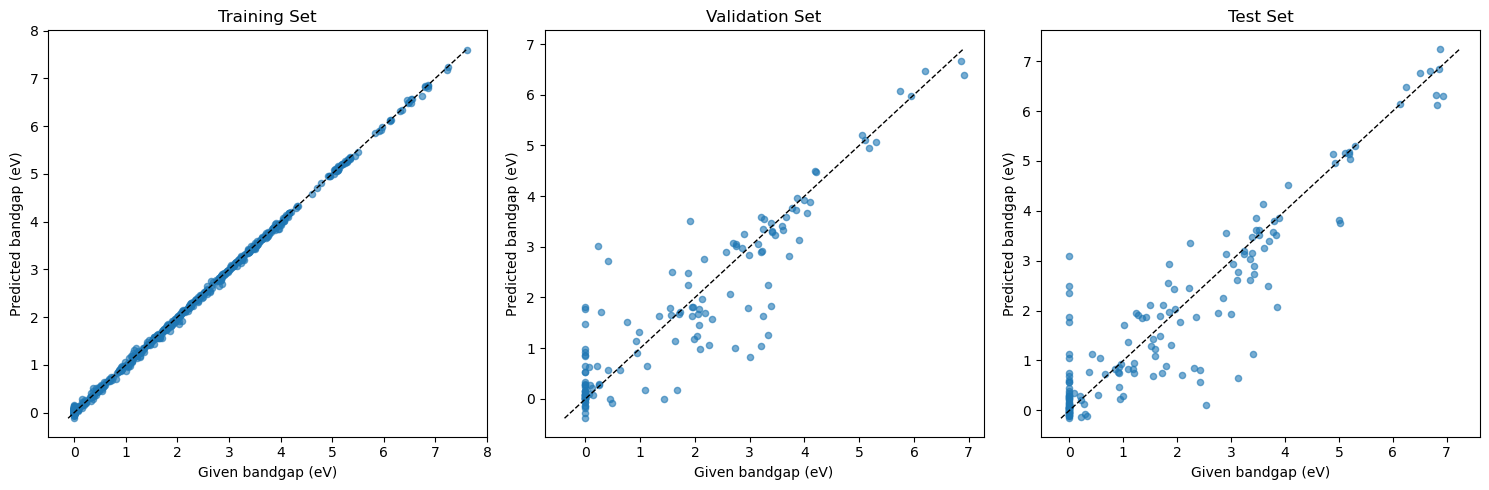

In [7]:
Y_train_pred = model.predict(X_train)
Y_val_pred   = model.predict(X_val)
Y_test_pred  = model.predict(X_test)

plot_cor(Y_train, Y_train_pred,Y_val,   Y_val_pred, Y_test,  Y_test_pred)


In [8]:
def comps(Y_test, Y_test_pred,paper_mae=0.211, paper_rmse=0.259, paper_r2=0.934,title="Test Set Comparison"):
    
    mae  = mean_absolute_error(Y_test, Y_test_pred)
    rmse = mean_squared_error(Y_test, Y_test_pred, squared=False)
    r2   = r2_score(Y_test, Y_test_pred)
    
    labels = ["MAE", "RMSE", "R^2"]
    present_study = [mae, rmse, r2]
    paper_scores  = [paper_mae, paper_rmse, paper_r2]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(5,4))
    plt.bar(x - width/2, present_study, width,
            label="Present Study", color='deepskyblue')
    plt.bar(x + width/2, paper_scores, width,
            label="Paper (XGBoost)", color='yellowgreen')

    plt.xticks(x, labels)
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

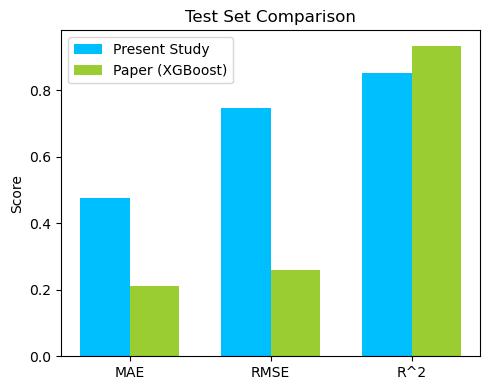

In [10]:
Y_test_pred = model.predict(X_test)

comps(Y_test, Y_test_pred)

The above results demonstrate classic **overfitting**.

XGBoost is easily memorizing the dataset (only 1053 samples), so this overfitting is expected. To overcome this, the paper uses 10-fold cross validation, such that:

- Train on 90% of data
- Test on 10% of data
- Repeat 10 times

## Part 2: With 10-fold cross-validation

In [11]:
# imports
from sklearn.model_selection import KFold

In [12]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

r2s = []
maes = []
rmses = []

print("Fold |   R2    |   MAE   |   RMSE")
print("----------------------------------")

fold = 1

for train_idx, val_idx in kf.split(X):
    X_train_cv = X.iloc[train_idx]
    Y_train_cv = Y.iloc[train_idx]
    X_val_cv = X.iloc[val_idx]
    Y_val_cv = Y.iloc[val_idx]
    
    # Apply same parameters as in part 1:
    
    model_cv = XGBRegressor(
        n_estimators = 300,
        learning_rate = 0.1, 
        gamma = 0,
        max_depth = 6,    
        subsample = 1,   
        colsample_bytree=0.8,
        reg_alpha = 0,
        reg_lambda = 1,

        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
    )

    model_cv.fit(X_train_cv, Y_train_cv)
    Y_pred_cv = model_cv.predict(X_val_cv)
    
    r2 = r2_score(Y_val_cv, Y_pred_cv)
    r2s.append(r2)
    mae = mean_absolute_error(Y_val_cv, Y_pred_cv)
    maes.append(mae)
    rmse = mean_squared_error(Y_val_cv, Y_pred_cv, squared=False)
    rmses.append(rmse)
    
    print(f"{fold:>4} | {r2:6.3f}  | {mae:7.3f} | {rmse:7.3f}")
    fold += 1
    
print("\nAverages over 10 folds:")
print(f"R^2   mean = {np.mean(r2s):.3f}, std = {np.std(r2s):.3f}")
print(f"MAE  mean = {np.mean(maes):.3f}, std = {np.std(maes):.3f}")
print(f"RMSE mean = {np.mean(rmses):.3f}, std = {np.std(rmses):.3f}")


Fold |   R2    |   MAE   |   RMSE
----------------------------------
   1 |  0.904  |   0.399 |   0.632
   2 |  0.777  |   0.512 |   0.797
   3 |  0.883  |   0.430 |   0.624
   4 |  0.788  |   0.516 |   0.801
   5 |  0.871  |   0.392 |   0.608
   6 |  0.859  |   0.443 |   0.678
   7 |  0.737  |   0.513 |   0.813
   8 |  0.883  |   0.417 |   0.637
   9 |  0.799  |   0.524 |   0.857
  10 |  0.865  |   0.443 |   0.724

Averages over 10 folds:
R^2   mean = 0.837, std = 0.053
MAE  mean = 0.459, std = 0.049
RMSE mean = 0.717, std = 0.088


Next, train separate model for the training, validation and test from the original 15% split

In [13]:
model = XGBRegressor(
    n_estimators = 300,
    learning_rate = 0.1, 
    gamma = 0,
    max_depth = 6,    
    subsample = 1,   
    colsample_bytree=0.8,
    reg_alpha = 0,
    reg_lambda = 1,
    
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

Next, evaluate.

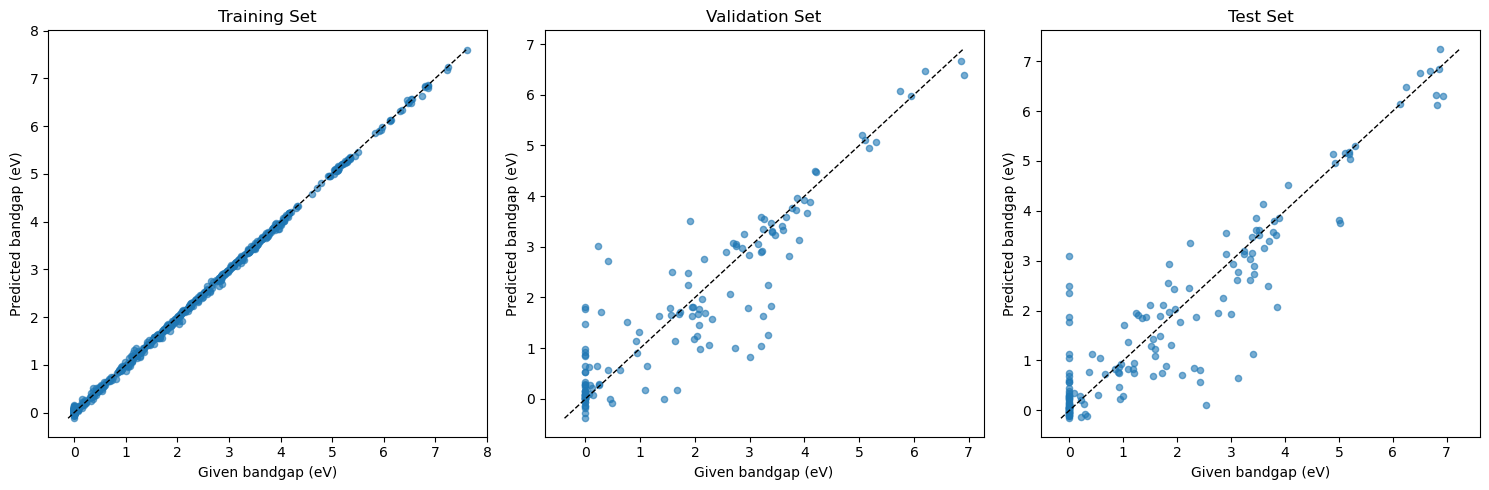

In [14]:
Y_train_pred = model.predict(X_train)
Y_val_pred   = model.predict(X_val)
Y_test_pred  = model.predict(X_test)

plot_cor(Y_train, Y_train_pred,Y_val,   Y_val_pred, Y_test,  Y_test_pred)

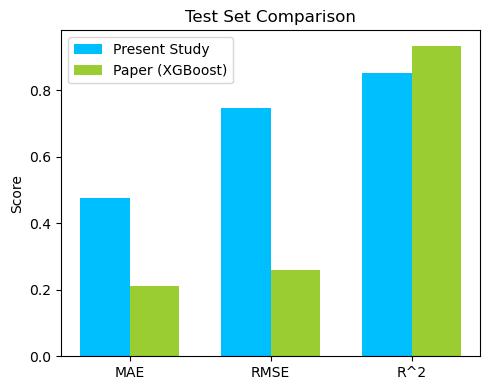

In [15]:
Y_test_pred = model.predict(X_test)

comps(Y_test, Y_test_pred)